In [1]:
seurat = readRDS('initialSeurat.RDS')
hash_data = readRDS('cell hashing/hashed_meta.RDS')
tcr = readRDS('tcr/TCR_df.RDS')
table(hash_data$hash)


 Doublet    HTO10     HTO6     HTO7     HTO8     HTO9 Negative 
    6564     8860     5880     9337     8267     5870     8793 

In [2]:
options(repr.plot.res = 300, repr.plot.width = 4, repr.plot.height = 4)
source("functions.R")

Loading required package: ggplot2

Registered S3 methods overwritten by 'tibble':
  method     from  
  format.tbl pillar
  print.tbl  pillar

Loading required package: cowplot


********************************************************

Note: As of version 1.0.0, cowplot does not change the

  default ggplot2 theme anymore. To recover the previous

  behavior, execute:
  theme_set(theme_cowplot())

********************************************************


Loading required package: Matrix


Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union




In [3]:
seurat@meta.data$hash = hash_data[seurat@cell.names, 'hash']
rownames(tcr) = tcr$id
seurat@meta.data$id = paste0(seurat@meta.data$orig, seurat@meta.data$bc)
cols = c('TRB_CDR3', 'TRBV', 'TCR_Recovery', 'TRBJ', 'TRB_nuc', 'TRA_CDR3', 'TRAV', 'TRAJ', 'TRA_nuc', 'TRA.2_CDR3', 'TRAV.2', 'TRAJ.2', 'TRA2_nuc')
seurat@meta.data[,cols] = tcr[seurat@meta.data$id, cols]


HTO10  HTO6  HTO7  HTO8  HTO9 
 5603  3857  6303  5035  3143 

Regressing out: n_genes




Time Elapsed:  52.146919965744 secs

Scaling data matrix

Warning message:
"Python 'C:\Users\dmorgan\AppData\Local\Continuum\anaconda3\envs\seqwell\python.exe' was requested but 'C:/Users/dmorgan/AppData/Local/r-miniconda/envs/r-reticulate/python.exe' was loaded instead (see reticulate::py_config() for more information)"
Regressing out: n_genes, percent.mito




Time Elapsed:  1.04788500070572 mins

Scaling data matrix



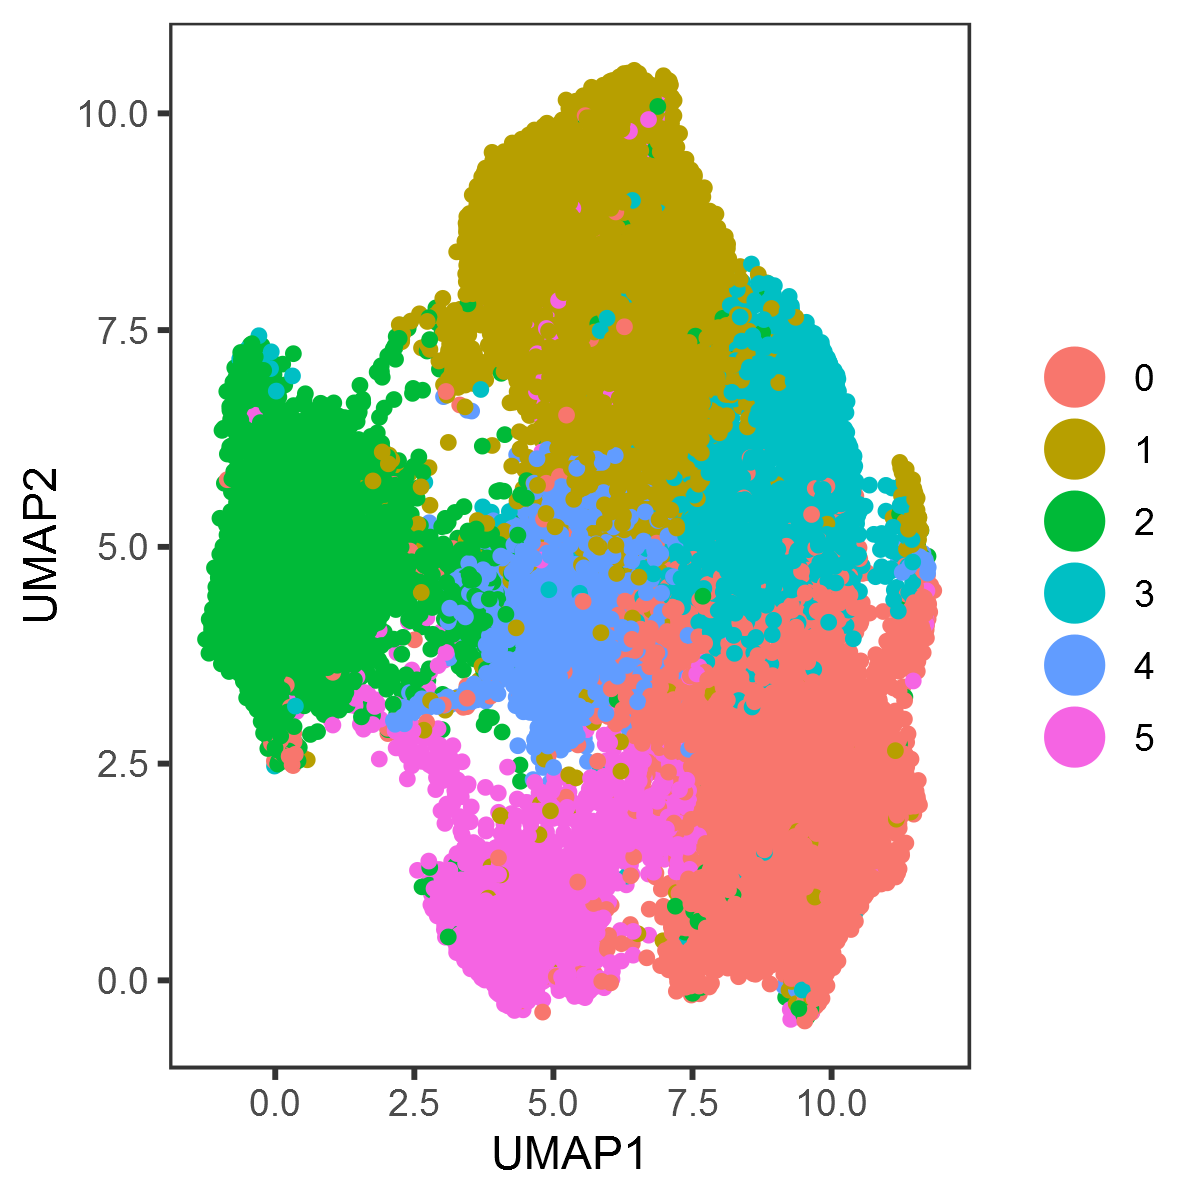

In [4]:
mito.genes = rownames(seurat@data)[grep(x = rownames(seurat@data), pattern = '^mt')]
seurat@meta.data$percent.mito = colSums(seurat@raw.data[mito.genes, seurat@cell.names])/colSums(seurat@raw.data[,seurat@cell.names])
seurat = SubsetData(seurat, seurat@cell.names[seurat@meta.data$n_genes > 500])
seurat = SubsetData(seurat, seurat@cell.names[!seurat@meta.data$hash %in% c('Negative','Doublet')])
seurat = SubsetData(seurat, seurat@cell.names[!is.na(seurat@meta.data$hash)])
seurat = SubsetData(seurat, seurat@cell.names[!seurat@meta.data$orig %in% c('R9', 'R10', 'R1', "R2")])
seurat = SubsetData(seurat, seurat@cell.names[seurat@meta.data$percent.mito < .20], subset.raw = TRUE)
table(seurat@meta.data$hash)
seurat = pyProcess(seurat)
seurat = ScaleData(seurat, vars.to.regress = c( 'n_genes', 'percent.mito'), model.use = 'poisson', genes.use = seurat@var.genes)
seurat = RunPCA(seurat, pcs.compute = 100, do.print = FALSE)
seurat = RunUMAP(seurat, dims.use = 1:50)
seurat = FindClusters(seurat, dims.use = 1:20, resolution = .3, print.output = FALSE, force.recalc = TRUE)
DimPlot(seurat, 'umap')

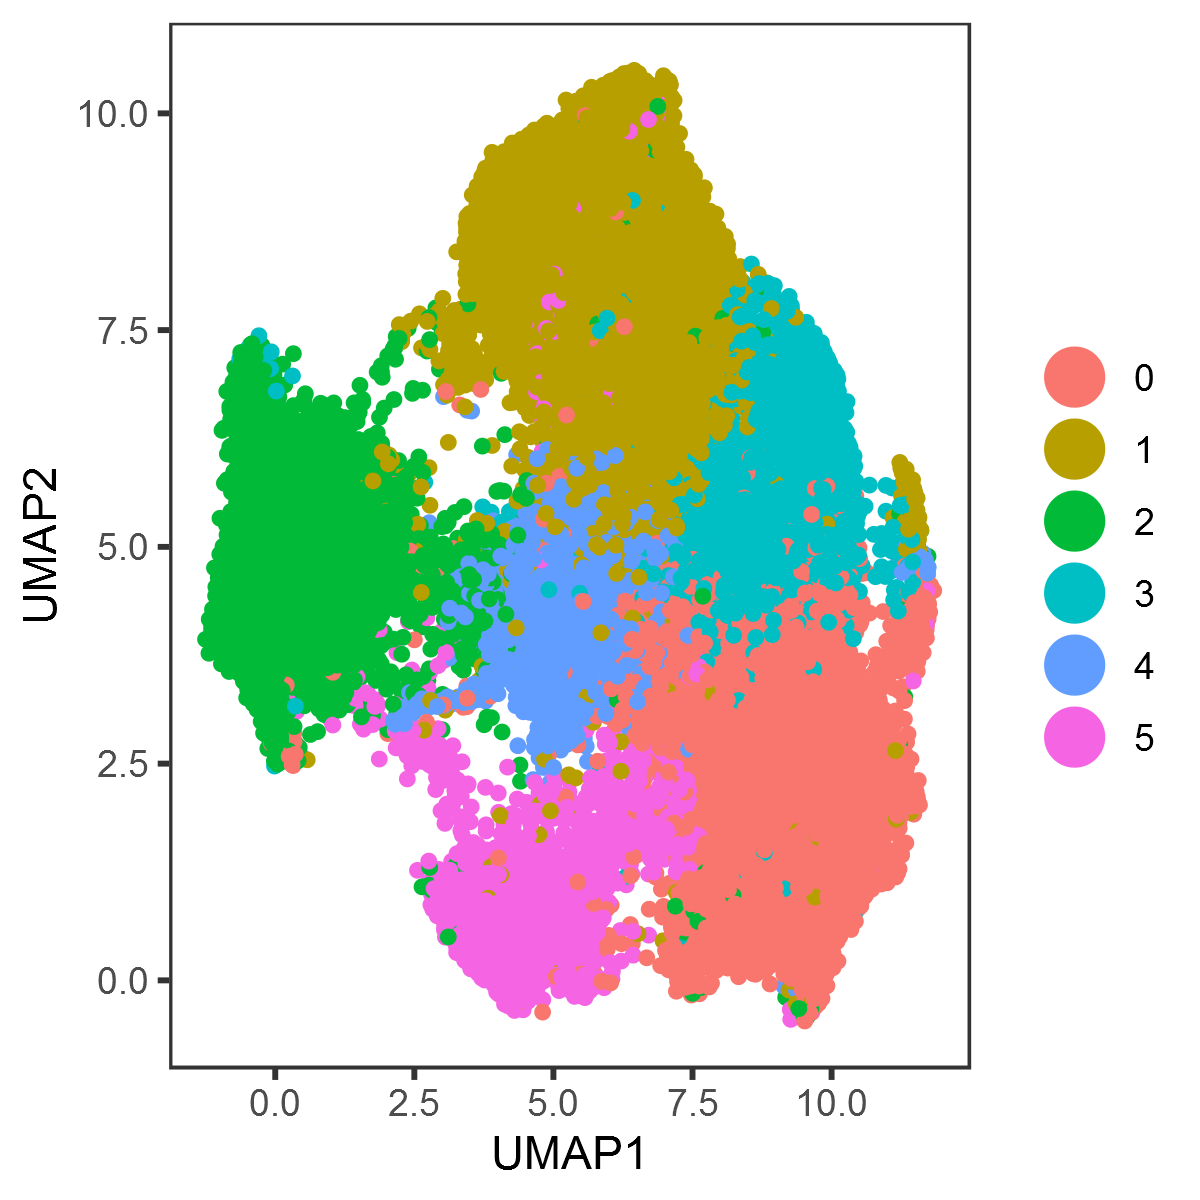

In [5]:
seurat = FindClusters(seurat, dims.use = 1:20, resolution = .4, print.output = FALSE, force.recalc = TRUE)
DimPlot(seurat, 'umap')

In [6]:
a = FindMarkers(seurat, 4, logfc.threshold = .25)
head(a, 10)

,p_val,avg_logFC,pct.1,pct.2,p_val_adj
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Gm26924,0.000000e+00,0.3152722,1.000,1.000,0.000000e+00
mmu-mir-6236,9.178157e-241,0.5677911,0.999,0.999,1.563866e-236
Lars2,1.104533e-156,0.3740881,0.981,0.995,1.882015e-152
B2m,1.167203e-133,-0.3568669,0.781,0.969,1.988797e-129
Calm1,5.651754e-131,-0.3466347,0.378,0.761,9.630024e-127
Arpc5,4.420189e-129,-0.3042123,0.248,0.606,7.531559e-125
Pabpc1,3.527940e-126,-0.3473922,0.514,0.880,6.011256e-122
Actr3,1.244253e-125,-0.3280110,0.359,0.743,2.120083e-121
Rpl23,1.784670e-125,-0.3718781,0.228,0.566,3.040900e-121


In [7]:
seurat@meta.data$group = 'CAR T'
seurat@meta.data$group[seurat@meta.data$orig %in% c('R7', 'R8', 'Q5', 'Q4')] = 'CAR T-Vax'
seurat@meta.data$group[seurat@meta.data$orig %in% c('R9',' R10')] = 'CAR T-Vax + anti-IFNg'
seurat@meta.data$letter = substring(seurat@meta.data$orig, 1, 1)
seurat@meta.data$time = ifelse(seurat@meta.data$letter == 'Q', 'Day 7', 'Day 14')
seurat@meta.data$time = factor(seurat@meta.data$time, levels =c ('Day 7', 'Day 14'))
seurat@meta.data$mouse = paste0(seurat@meta.data$group, seurat@meta.data$hash)


Regressing out: n_genes




Time Elapsed:  52.9431350231171 secs

Scaling data matrix



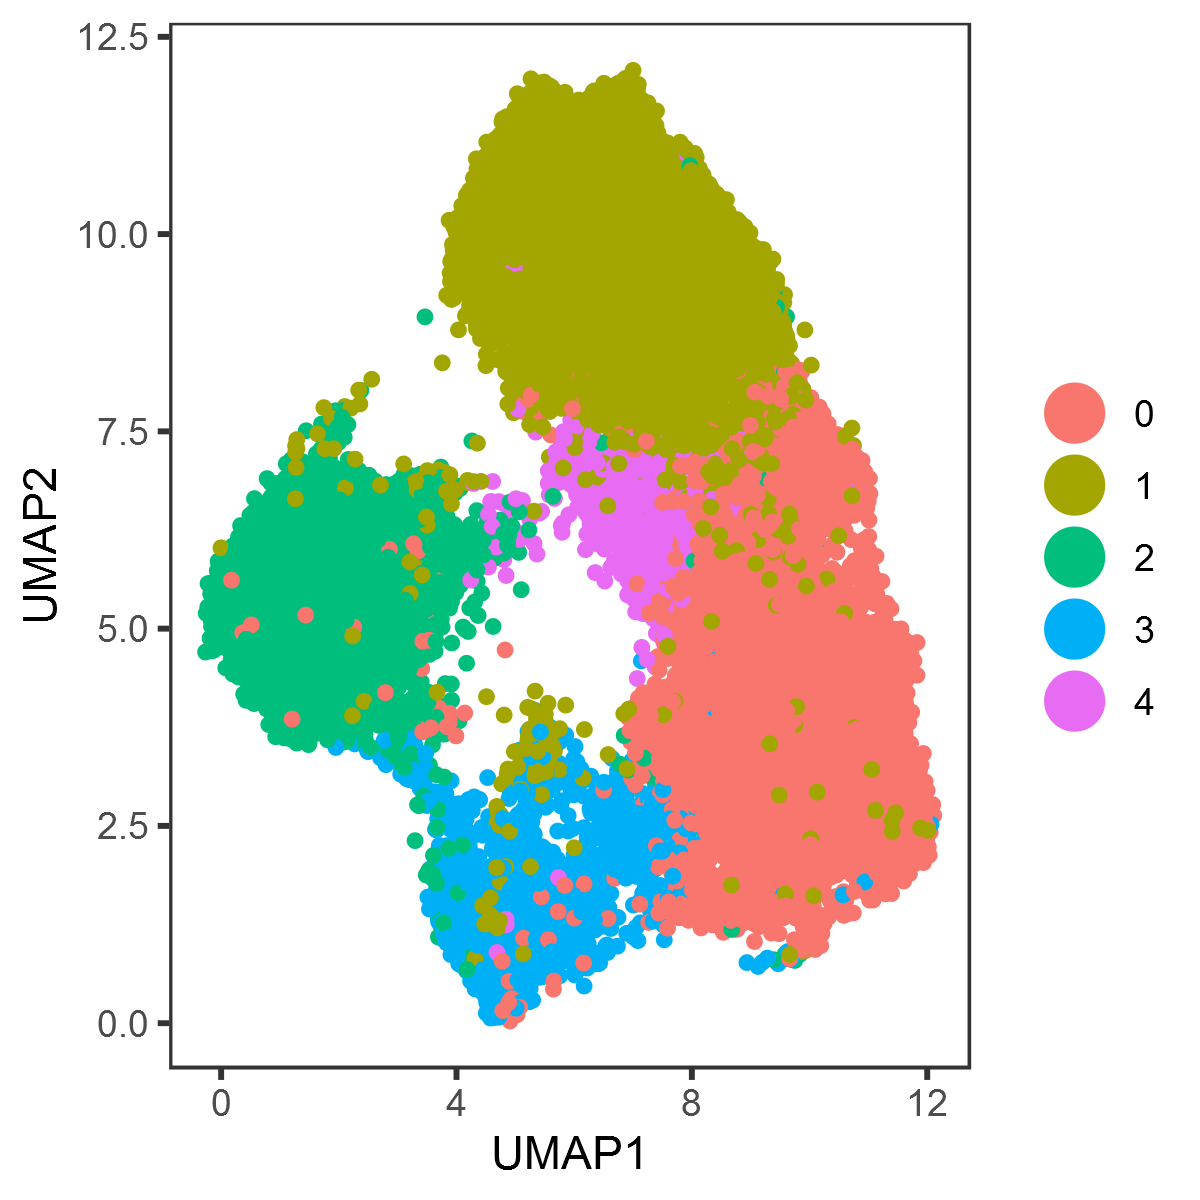

In [8]:
seurat2 = SubsetData(seurat, seurat@cell.names[seurat@meta.data$res.0.3 != 4])
seurat2 = SubsetData(seurat2, seurat@cell.names[seurat@meta.data$n_genes > 500])
seurat2 = FindVariableGenes(seurat2, do.plot = FALSE)
seurat2 = ScaleData(seurat2, vars.to.regress = c( 'n_genes'), model.use = 'poisson', genes.use = seurat2@var.genes)
seurat2 = RunPCA(seurat2, pcs.compute = 100, do.print = FALSE)
seurat2 = RunUMAP(seurat2, dims.use = 1:50)
seurat2 = FindClusters(seurat2, dims.use = 1:20, resolution = .2, print.output = FALSE, force.recalc = TRUE)
DimPlot(seurat2, 'umap')

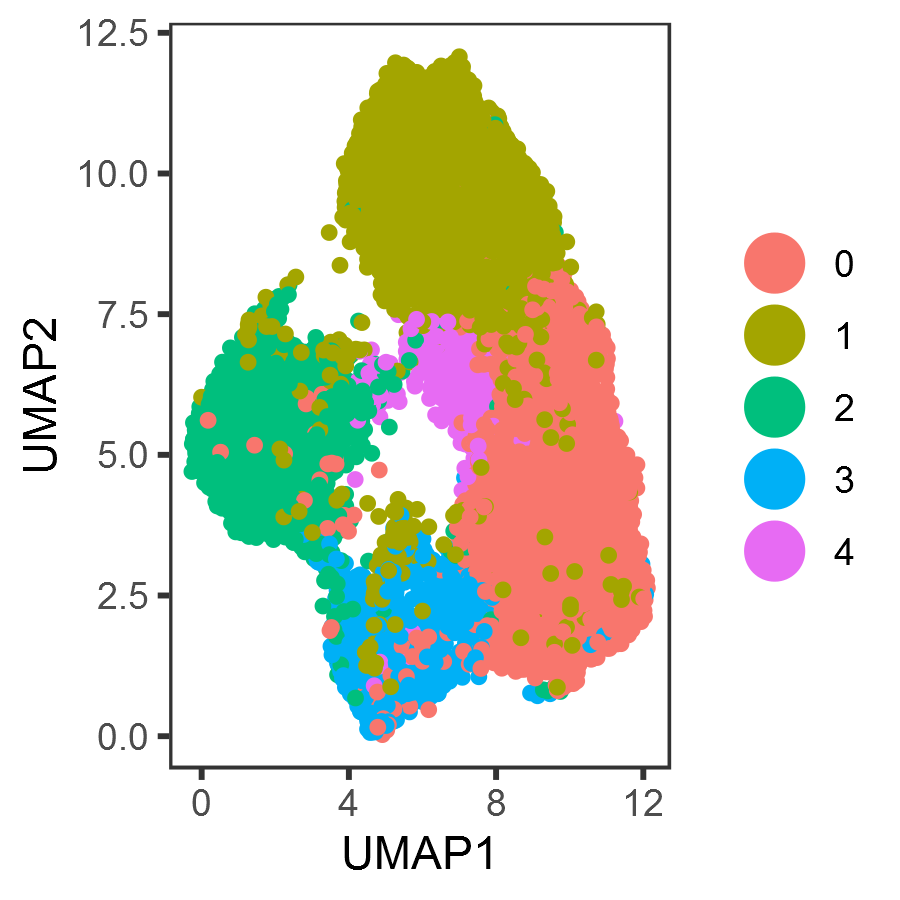

In [9]:
options(repr.plot.width = 3, repr.plot.height = 3)

seurat2 = FindClusters(seurat2, dims.use = 1:30, resolution = .2, print.output = FALSE, force.recalc = TRUE, n.iter = 100)
DimPlot(seurat2, 'umap')

In [10]:
source('figure_parameters.R')


CAR T-Vax_Day 14  CAR T-Vax_Day 7     CAR T_Day 14      CAR T_Day 7 
            1641             5193             8652             6349 

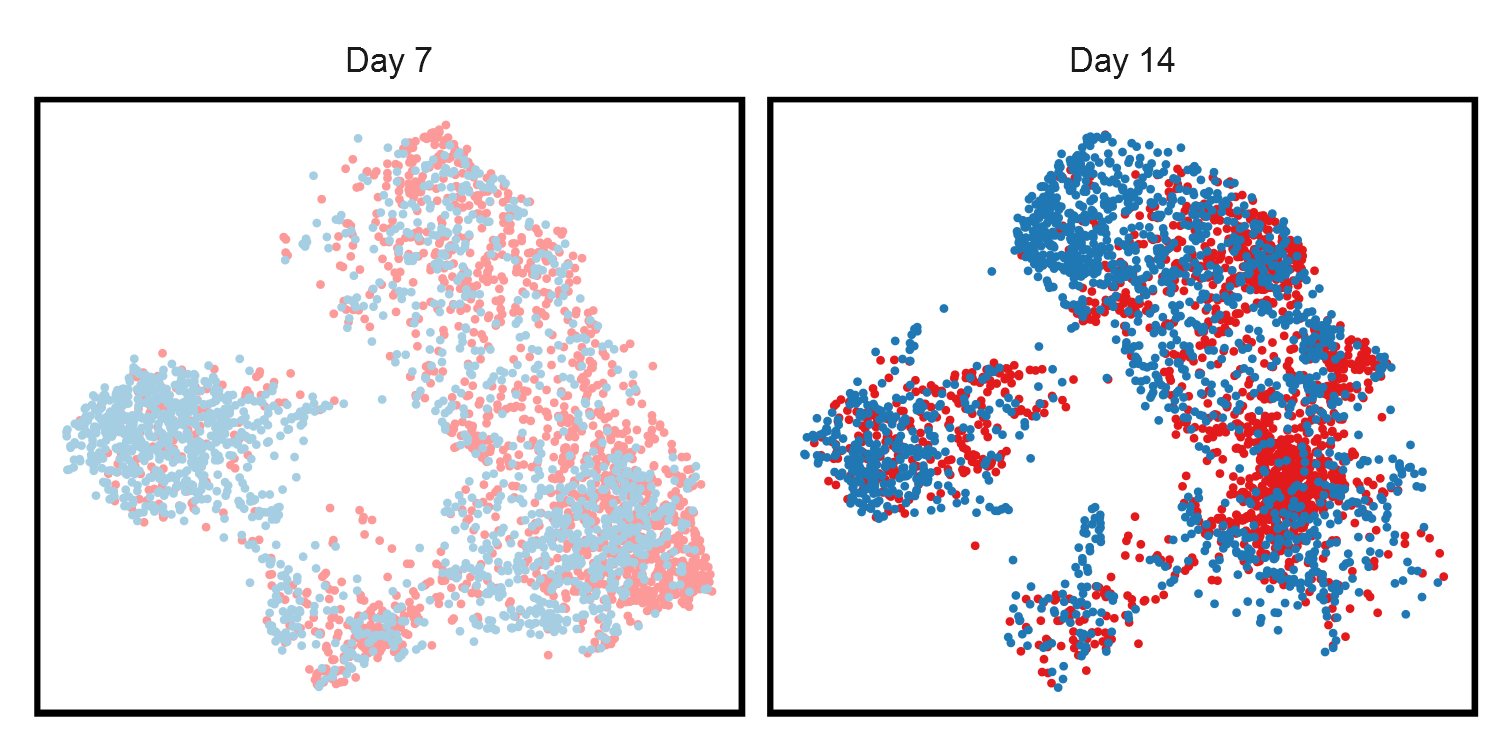

In [11]:
seurat2 = addUMAP(seurat2)
options(repr.plot.width = 5, repr.plot.height = 2.5)


seurat2@meta.data$group = factor(seurat2@meta.data$group, levels = c('CAR T', 'CAR T-Vax'))
seurat2@meta.data$group_time = paste0(seurat2@meta.data$group, '_', seurat2@meta.data$time)
table(seurat2@meta.data$group_time)


condition_palette = brewer.pal(10, 'Paired')[c(6,5,2,1)]
names(condition_palette) =  names(table(seurat2@meta.data$group_time))
set.seed(1)
ggplot(shuffle(seurat2@meta.data) %>% group_by(group_time) %>% sample_n(1641), aes(x = UMAP1, y = UMAP2, color = group_time)) + geom_point(size = .1) + UMAP_theme + scale_color_manual(values = condition_palette) + facet_wrap('time') +
theme(strip.text = element_text(size = 6), strip.background = element_blank())


ggsave('Figures/condition_umap.pdf', height = 2.2, width = 4, useDingbats = FALSE)

In [12]:
pheno_palette = c('#6388b4', '#ffae34', '#ef6f6a', '#8cc2ca', '#55ad89')#[c(1,2,5,4,3)]
names(pheno_palette) = c('CD4+ Th', 'CD8+ CTL', 'IFN-activated', 'Ki-67+', 'Treg')

seurat2@meta.data$pheno = 'CD8+ CTL'
seurat2@meta.data$pheno[seurat2@meta.data$res.0.2 == 3] = 'Ki-67+'
seurat2@meta.data$pheno[seurat2@meta.data$res.0.2 == 1] = 'CD4+ Th'
seurat2@meta.data$pheno[seurat2@meta.data$res.0.2 == 2] = 'Treg'
seurat2@meta.data$pheno[seurat2@meta.data$res.0.2 == 4] = 'IFN-activated'

seurat2@meta.data$pheno = factor(seurat2@meta.data$pheno, levels = c('CD4+ Th', 'CD8+ CTL', 'Treg', 'Ki-67+', 'IFN-activated'))

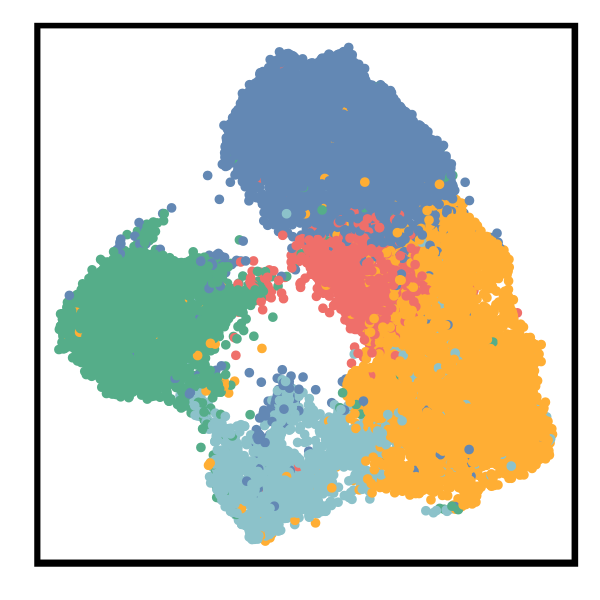

In [13]:
seurat2 = addUMAP(seurat2)
options(repr.plot.width = 2, repr.plot.height = 2)
ggplot(shuffle(seurat2@meta.data) , aes(x = UMAP1, y = UMAP2, color =pheno)) + geom_point(size = .2) + UMAP_theme + scale_color_manual(values = pheno_palette)

ggsave('Figures/pheno_umap.pdf', height = 2, width = 2, useDingbats = FALSE)


CAR T-Vax_Day 14  CAR T-Vax_Day 7     CAR T_Day 14      CAR T_Day 7 
            1641             5193             8652             6349 

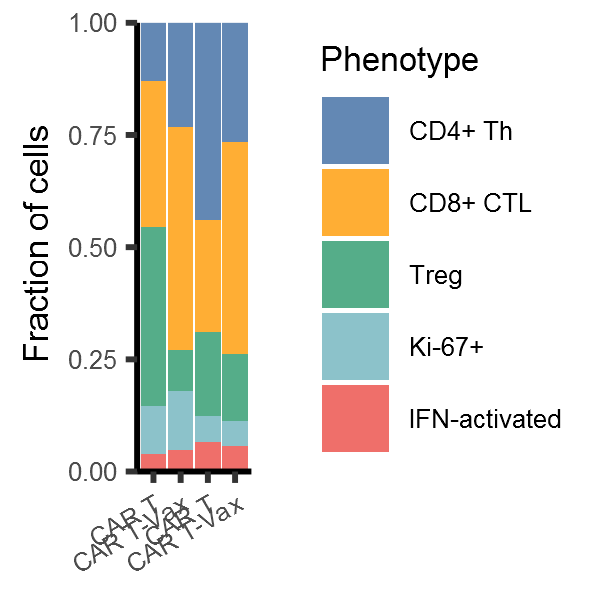

In [14]:

options(repr.plot.width = 2, repr.plot.height =2 )
table(seurat2@meta.data$group_time)
seurat2@meta.data$group_time = factor(seurat2@meta.data$group_time, levels = c('CAR T_Day 7', 'CAR T-Vax_Day 7', 'CAR T_Day 14', 'CAR T-Vax_Day 14'))
ggplot(seurat2@meta.data, aes(x = group_time, fill = pheno)) + geom_bar(position = 'fill') + scale_fill_manual(values = pheno_palette) + 
theme_classic() + scale_y_continuous(limits = c(0, 1), expand = expansion(mult = c(0, 0))) + Axis_themes + 
labs(x = c(), y = 'Fraction of cells', fill = 'Phenotype') + theme(axis.text.x = element_text(angle = 30, hjust = 1)) +
scale_x_discrete(labels = c('CAR T', 'CAR T-Vax', 'CAR T', 'CAR T-Vax'))
ggsave('Figures/pheno_condition.pdf', height = 2.5, width = 2.5, useDingbats = FALSE)

In [15]:
pct = function(x) {
  sum(x >0)/length(x)
}
meanexp = function(x) {
    mean(x)
}

Loading required package: viridisLite


Attaching package: 'viridis'


The following object is masked from 'package:viridisLite':

    viridis.map




character(0)

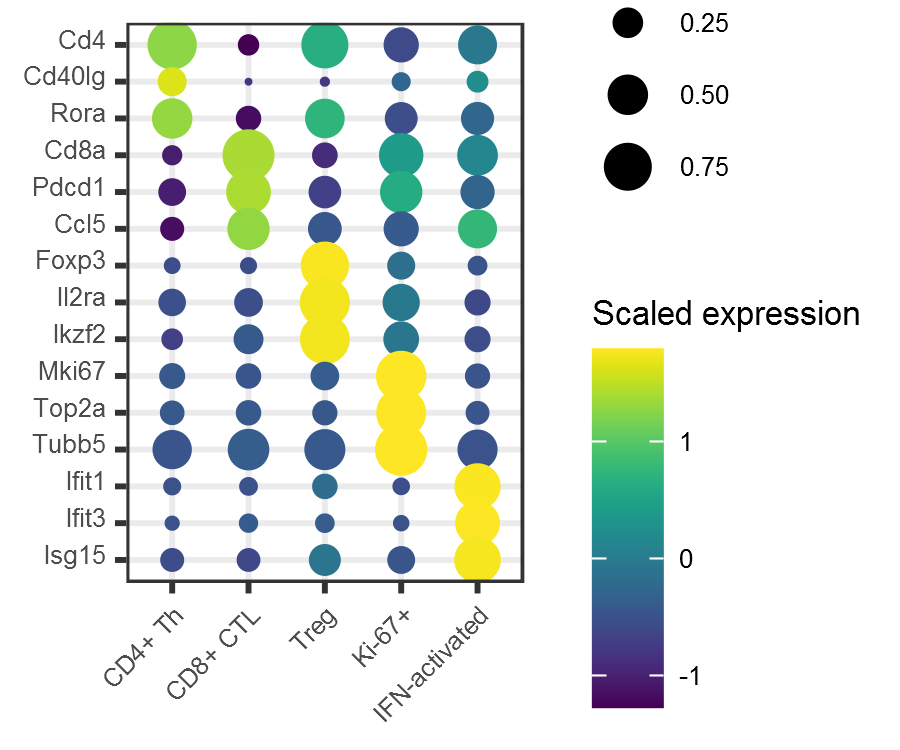

In [16]:
library(reshape2)
library(viridis)
library(stringr)
options(repr.plot.width = 3, repr.plot.height = 2.5)
genes = c( 'CD4', 'CD40LG', 'Rora', "CD8A", 'PDCD1', 'CCL5','FOXP3','IL2RA', 'IKZF2', 'MKI67','TOP2A', 'TUBB5', 'IFIT1', 'IFIT3','ISG15') %>% str_to_title()
genes[!genes %in% rownames(seurat2@data)]
data = as.data.frame(t(as.matrix(seurat2@data[genes,])))
data$phenotype = seurat2@meta.data$pheno
df_exp = data %>% group_by(phenotype) %>% summarize_all(.funs = list(meanexp)) %>% as.data.frame() 
df_exp[,2:(1+length(genes))] = scale(df_exp[,2:(1+length(genes))])
df_exp = df_exp %>% melt(id.vars = 'phenotype')
df_pct = data %>% group_by(phenotype) %>% summarize_all(.funs = list(pct)) %>% melt(id.vars = 'phenotype')
df_exp$value[df_exp$value > 2.5] = 2.5
df_exp$value[df_exp$value < -1.5]= -1.5
df_exp$pct = df_pct$value


lvs = levels(factor(df_exp$phenotype))
ggplot(as.data.frame(df_exp), aes(y = phenotype, x = variable, size = pct, color = value)) + geom_point() + scale_color_viridis()  + 
 theme_bw()  + theme(axis.title = element_blank(), axis.text.x = element_text(angle = 90)) + 
labs(color = "Scaled expression", size = 'Fraction\nof cells expressing') + scale_x_discrete(limits =rev( genes), labels = rev(str_to_title(genes))) + Axis_themes + 
theme(axis.title = element_blank(), axis.text = element_text(size = 6, hjust = 1, vjust = 0.2)) + scale_y_discrete(limits = (lvs))  + coord_flip() + 
scale_size(range = c(0, 5)) + theme(axis.text.x = element_text(angle = 45, hjust = 1))

ggsave('Figures/marker_genes.pdf', height = 3.5, width = 3.5, useDingbats = FALSE)

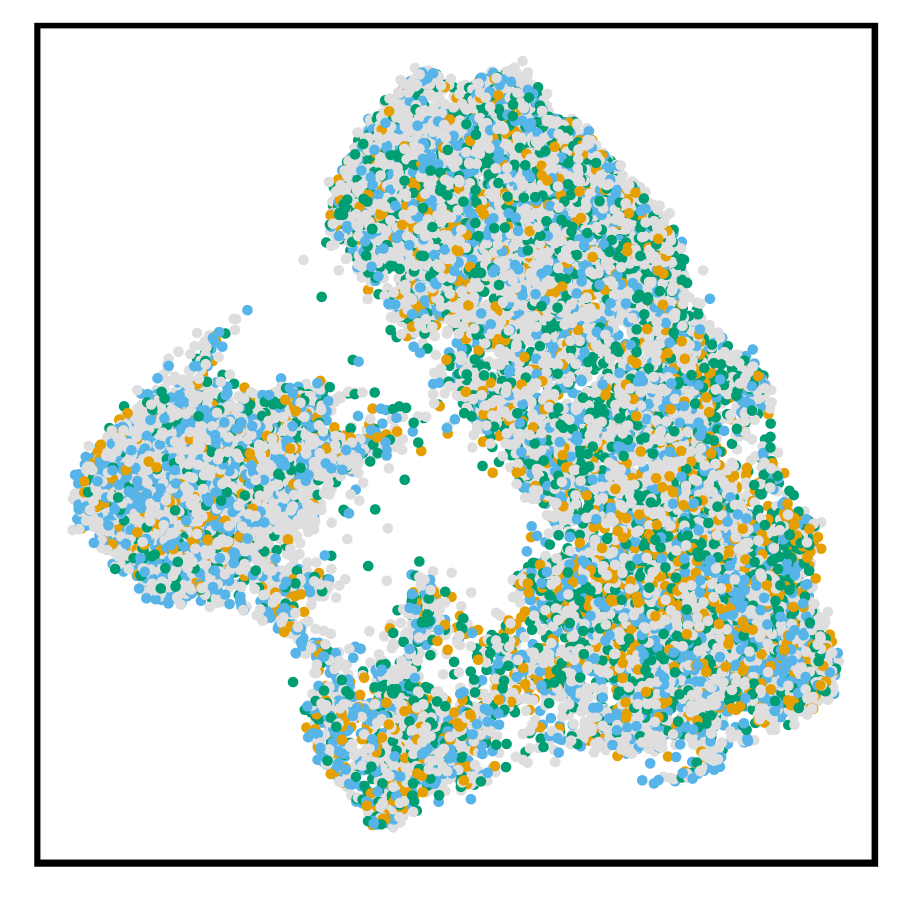

In [18]:
options(repr.plot.width = 3, repr.plot.height =3 )
ggplot(shuffle(seurat2@meta.data), aes(x = UMAP1, y = UMAP2, color= TCR_Recovery)) + geom_point(size = .3) + UMAP_theme + scale_color_manual(values = cbPalette)
ggsave('Figures/tcr_umap.pdf', height = 2.5, width = 2.5, useDingbats = FALSE)

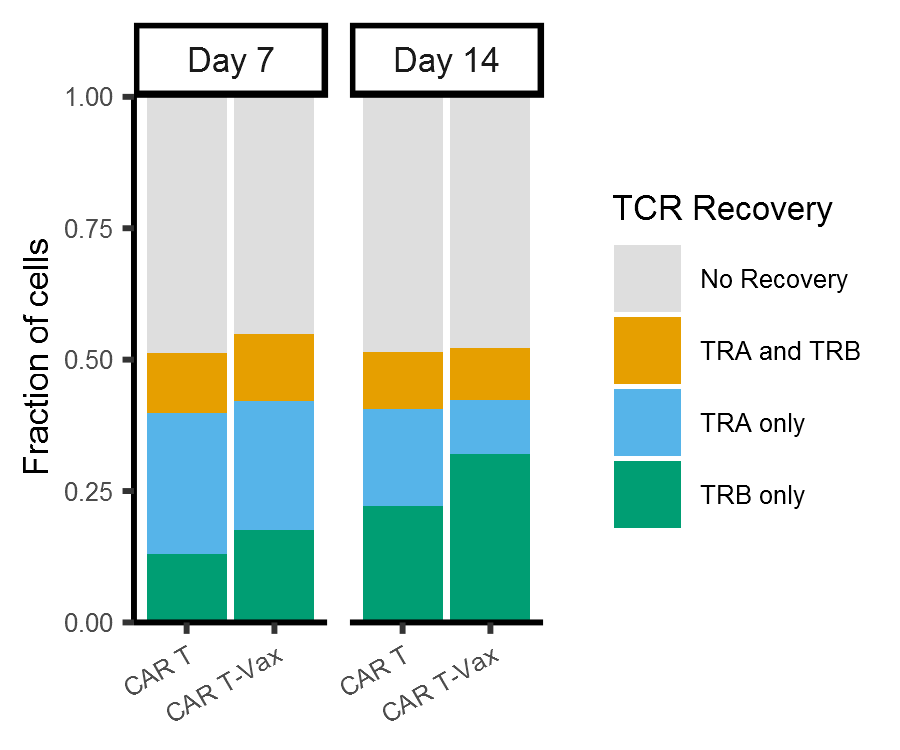

In [19]:
options(repr.plot.width =3 , repr.plot.height =2.5 )

ggplot(seurat2@meta.data, aes(x  = group, fill = TCR_Recovery)) + geom_bar(position = 'fill') + scale_fill_manual(values = cbPalette) + 
theme_classic() + scale_y_continuous(expand = c(0,0)) + theme(axis.text.x = element_text(angle = 30, hjust = 1)) + labs(x = c(), y = 'Fraction of cells', fill = 'TCR Recovery') + Axis_themes + 
facet_wrap('time')

ggsave('Figures/tcr_bar.pdf', height = 2.5, width = 3, useDingbats = FALSE)

In [20]:
a = table(seurat2@meta.data$TCR_Recovery)
(a[4] + a[2])/sum(a)
a = table(seurat2@meta.data$TCR_Recovery)
(a[3] + a[2])/sum(a)
(a[2])/sum(a)


TRB only 
0.3040531

TRA only 
0.3314861

TRA and TRB 
  0.1135791

,p_val,avg_logFC,pct.1,pct.2,p_val_adj
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Trav6-1,1.294845e-73,-0.3086475,0.000,0.147,2.206286e-69
Trbv26,1.894030e-71,-0.4500228,0.039,0.263,3.227237e-67
mt-Rnr2,2.874652e-61,-0.2290805,1.000,1.000,4.898119e-57
Ccl5,2.434945e-57,-0.6356307,0.674,0.905,4.148902e-53
Trbc1,7.387064e-52,-0.5799090,0.368,0.666,1.258682e-47



background     group1     group2 
      4804          4          5 

Warning message:
"Removed 4804 rows containing missing values (geom_text_repel)."
Warning message:
"Removed 4804 rows containing missing values (geom_text_repel)."


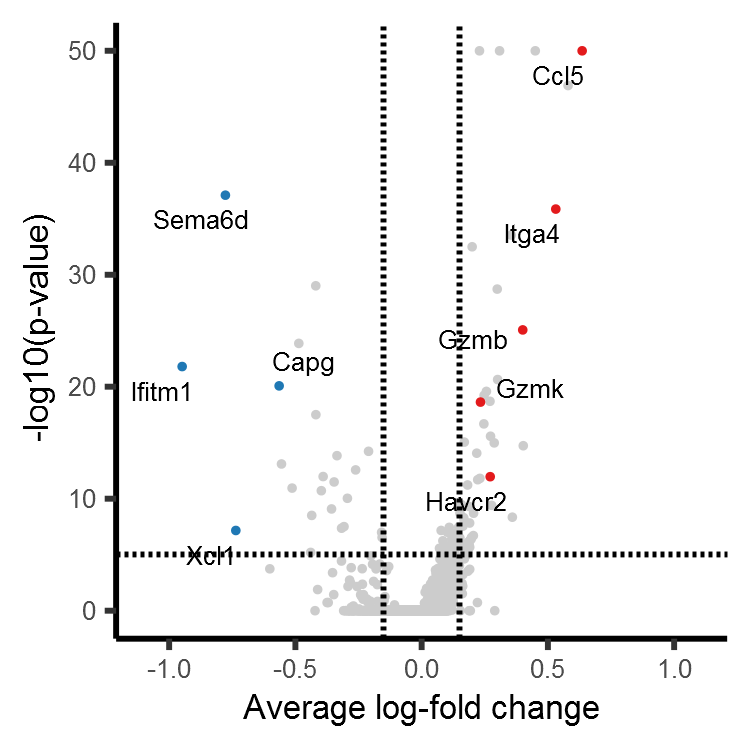

In [21]:
library(ggrepel)
seurat2@meta.data$three = paste(seurat2@meta.data$group, seurat2@meta.data$pheno, seurat2@meta.data$time, sep = '_')
#table(seurat@meta.data$three)
options(repr.plot.width = 2.5, repr.plot.height = 2.5)

seurat2 = SetAllIdent(seurat2, 'three')#
a = FindMarkers(seurat2, 'CAR T_CD8+ CTL_Day 14', 'CAR T-Vax_CD8+ CTL_Day 14', logfc.threshold = 0)
#a = read.table( 'vax14-vs_cart14.csv', sep = ',', header = TRUE, row.names = 1)
head(a, 5)
rownames(a) =str_to_title(rownames(a))
markers.plot = c('Ccl5', 'Gzmb', 'Havcr2', 'Itga4',  'Xcl1', 'Gzmk','Tnfsf8', 'Ccr7',  'Ccl1', 'Ifitm1','Sema6d', 'Capg')
a$format_gene = str_to_title(rownames(a))
a$label = a$format_gene
a$label[!a$format_gene %in% markers.plot] = NA

a$avg_logFC[a$avg_logFC < -1] = -1

a$color = 'background'
a$color[!is.na(a$label)] = 'group1'
a$color[!is.na(a$label) & a$avg_logFC < 0] = 'group2'
a$p_val_plot = a$p_val_adj
a$p_val_plot[a$p_val_adj < 1e-50] = 1e-50

table(a$color)

ggplot(a, aes(x = -avg_logFC, y = -log10(p_val_plot), color = color)) + geom_point(size = .2) + theme_classic() + scale_x_continuous(limits = c(-1.1, 1.1)) + Axis_themes + labs(x = 'Average log-fold change', y = '-log10(p-value)') + 
guides(color = FALSE) + geom_text_repel(aes(label = label), size = 2.11667, color = 'black') + scale_color_manual(values = c('grey80', condition_palette[c(3,1)])) + 
geom_hline(yintercept = 5, linetype = 'dashed') + geom_vline(xintercept = .15, linetype = 'dashed') + geom_vline(xintercept = -.15, linetype = 'dashed')




ggsave('Figures/cd8_only_vax_volano.pdf', height = 2.5, width = 2.5, useDingbats = FALSE)
write.csv(a, 'GeneLists/vax14-vs_cart14.csv')

,p_val,avg_logFC,pct.1,pct.2,p_val_adj
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Rpl35a,5.784482e-103,-0.4962080,0.288,0.622,9.856179e-99
Rps18,7.998701e-103,-0.4981186,0.747,0.876,1.362899e-98
Rn7sk,1.766744e-100,-0.5968845,0.196,0.508,3.010355e-96
Rps27,1.662727e-98,-0.4945881,0.452,0.756,2.833120e-94
Ly6c2,2.993532e-97,0.7569071,0.685,0.451,5.100680e-93



background     group1     group2 
      5279          4          5 

Warning message:
"Removed 5279 rows containing missing values (geom_text_repel)."
Warning message:
"Removed 5279 rows containing missing values (geom_text_repel)."


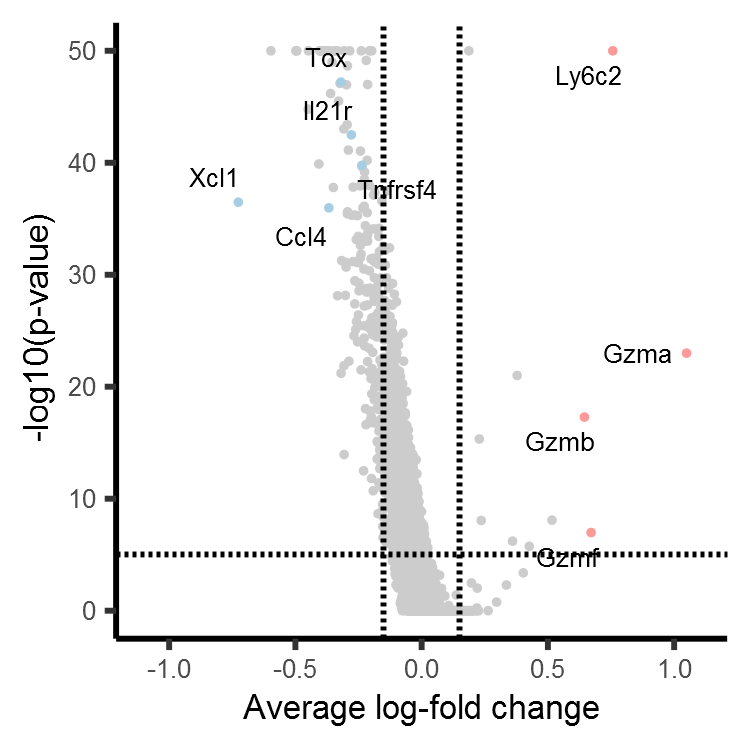

In [22]:
library(ggrepel)

a = FindMarkers(seurat2, 'CAR T-Vax_CD8+ CTL_Day 7', 'CAR T_CD8+ CTL_Day 7', logfc.threshold = 0)
#a = read.table( 'vax7_only7.csv', sep = ',', header = TRUE, row.names = 1)

head(a, 5)
rownames(a) =str_to_title(rownames(a))
markers.plot = c('Tox', 'Il21r', 'Tnfrsf4', 'Xcl1','Ccl4', 'Gzma', 'Gzmb', 'Gzmf', 'Ly6c2')
a$format_gene = str_to_title(rownames(a))
a$label = a$format_gene
a$label[!a$format_gene %in% markers.plot] = NA

a$avg_logFC[a$avg_logFC < -1] = -1

a$color = 'background'
a$color[!is.na(a$label)] = 'group1'
a$color[!is.na(a$label) & a$avg_logFC < 0] = 'group2'
a$p_val_plot = a$p_val_adj
a$p_val_plot[a$p_val_adj < 1e-50] = 1e-50

table(a$color)

ggplot(a %>% arrange(!is.na(label)), aes(x = avg_logFC, y = -log10(p_val_plot), color = color)) + geom_point(size = .2) + theme_classic() + scale_x_continuous(limits = c(-1.1, 1.1)) + Axis_themes + labs(x = 'Average log-fold change', y = '-log10(p-value)') + 
guides(color = FALSE) + geom_text_repel(aes(label = label), size = 2.11667, color = 'black') + scale_color_manual(values = c('grey80', condition_palette[c(2,4)])) +
geom_hline(yintercept = 5, linetype = 'dashed') + geom_vline(xintercept = .15, linetype = 'dashed') + geom_vline(xintercept = -.15, linetype = 'dashed')




ggsave('Figures/cd8day7.pdf', height = 2.5, width = 2.5, useDingbats = FALSE)
write.csv(a, 'GeneLists/vax7_only7.csv')

,p_val,avg_logFC,pct.1,pct.2,p_val_adj
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Slamf6,1.162746e-43,-0.3806837,0.057,0.247,1.981202e-39
Trbv13-3,1.221442e-41,-0.3811693,0.021,0.144,2.081215e-37
Aldoa,3.547858e-36,0.8781941,0.754,0.666,6.045195e-32
Ms4a4b,5.450033e-35,-0.5061932,0.485,0.799,9.286312e-31
Tcf7,3.347484e-34,-0.5294847,0.253,0.538,5.703778e-30



background     group1     group2 
      7907          6          4 

Warning message:
"Removed 7907 rows containing missing values (geom_text_repel)."
Warning message:
"Removed 7907 rows containing missing values (geom_text_repel)."


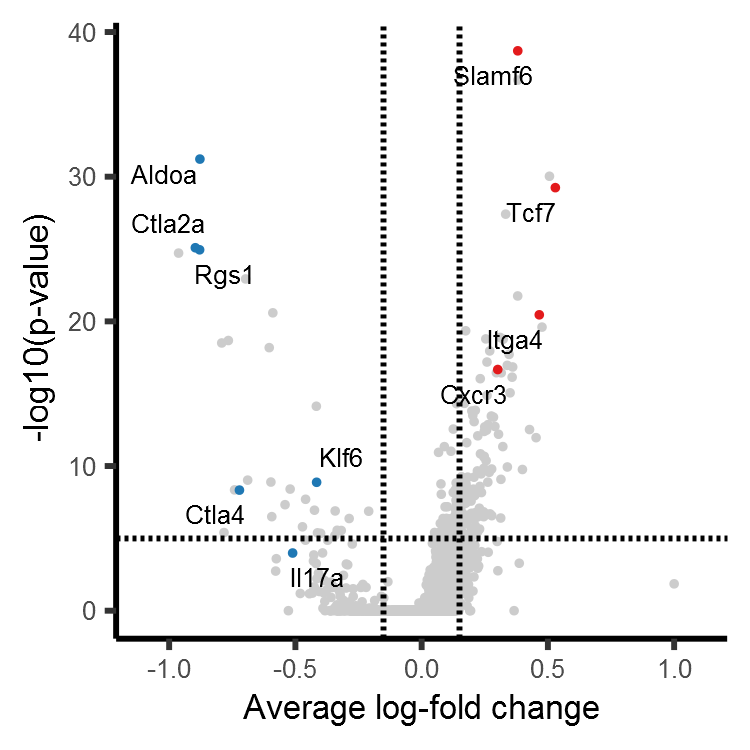

In [23]:
library(ggrepel)
#table(seurat@meta.data$three)
options(repr.plot.width = 2.5, repr.plot.height = 2.5)

a = FindMarkers(seurat2, 'CAR T_CD4+ Th_Day 14', 'CAR T-Vax_CD4+ Th_Day 14', logfc.threshold = 0, min.pct = 0.03)

head(a, 5)
rownames(a) =str_to_title(rownames(a))
markers.plot = c('Slamf6', 'Tcf7', 'Itga4',' S1pr1', 'Cxcr3', 'Aldoa', 'Rgs1', 'Ctla2a', 'Ctla4', 'Klf6','Il17a')
a$format_gene = str_to_title(rownames(a))
a$label = a$format_gene
a$label[!a$format_gene %in% markers.plot] = NA

a$avg_logFC[a$avg_logFC < -1] = -1

a$color = 'background'
a$color[!is.na(a$label)] = 'group1'
a$color[!is.na(a$label) & a$avg_logFC < 0] = 'group2'
a$p_val_plot = a$p_val_adj
a$p_val_plot[a$p_val_adj < 1e-50] = 1e-50

table(a$color)

ggplot(a %>% arrange(!is.na(label)), aes(x = -avg_logFC, y = -log10(p_val_plot), color = color)) + geom_point(size = .2) + theme_classic() + scale_x_continuous(limits = c(-1.1, 1.1)) + Axis_themes + labs(x = 'Average log-fold change', y = '-log10(p-value)') + 
guides(color = FALSE) + geom_text_repel(aes(label = label), size = 2.11667, color = 'black') + scale_color_manual(values = c('grey80', condition_palette[c(3,1)])) + 
geom_hline(yintercept = 5, linetype = 'dashed') + geom_vline(xintercept = .15, linetype = 'dashed') + geom_vline(xintercept = -.15, linetype = 'dashed')




ggsave('Figures/d14_vax_only_cd4.pdf', height = 2.5, width = 2.5, useDingbats = FALSE)
write.csv(a, 'GeneLists/cd4_vax14_cart14.csv')

,p_val,avg_logFC,pct.1,pct.2,p_val_adj
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Rpl35a,1.481759e-48,0.5362112,0.525,0.196,2.524769e-44
Fau,4.025843e-48,0.4726168,0.888,0.714,6.859633e-44
Rps27,1.450508e-45,0.5045927,0.739,0.411,2.471521e-41
Rps18,3.848230e-41,0.4820444,0.835,0.603,6.556999e-37
Rps28,8.033279e-39,0.4503010,0.535,0.230,1.368790e-34



background     group1     group2 
      1284          4          1 

Warning message:
"Removed 1284 rows containing missing values (geom_text_repel)."
Warning message:
"Removed 1284 rows containing missing values (geom_text_repel)."


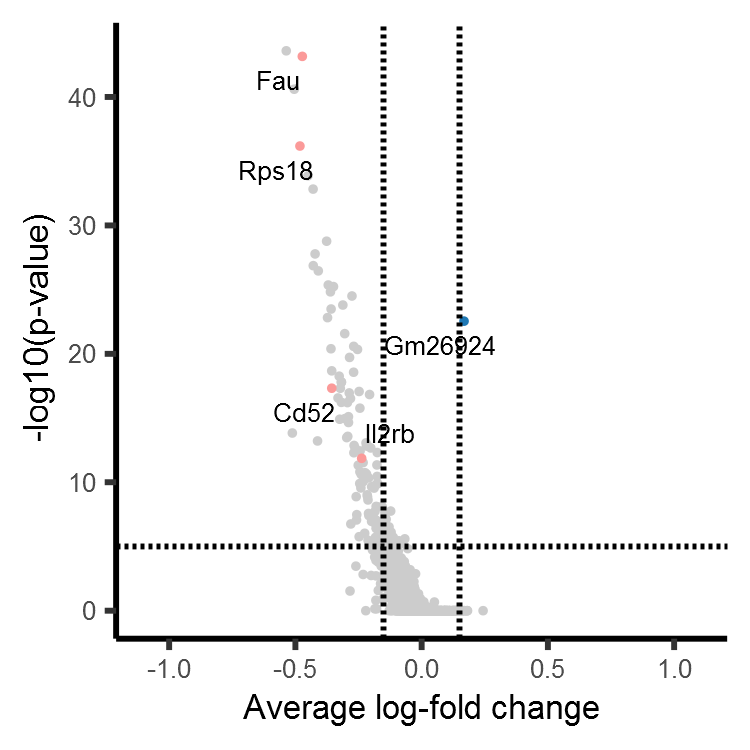

In [24]:
library(ggrepel)
a = FindMarkers(seurat2, 'CAR T_CD4+ Th_Day 7', 'CAR T-Vax_CD4+ Th_Day 7', logfc.threshold = 0, min.pct = .3)


head(a, 5)
rownames(a) =str_to_title(rownames(a))
markers.plot = c('Fau', 'Rps18', 'Cd52', 'Flt1', 'Il2rb', 'Gm26924')
a$format_gene = str_to_title(rownames(a))
a$label = a$format_gene
a$label[!a$format_gene %in% markers.plot] = NA

a$avg_logFC[a$avg_logFC < -1] = -1

a$color = 'background'
a$color[!is.na(a$label)] = 'group1'
a$color[!is.na(a$label) & a$avg_logFC < 0] = 'group2'
a$p_val_plot = a$p_val_adj
a$p_val_plot[a$p_val_adj < 1e-50] = 1e-50

table(a$color)

ggplot(a %>% arrange(!is.na(label)), aes(x = -avg_logFC, y = -log10(p_val_plot), color = color)) + geom_point(size = .2) + theme_classic() + scale_x_continuous(limits = c(-1.1, 1.1)) + Axis_themes + labs(x = 'Average log-fold change', y = '-log10(p-value)') + 
guides(color = FALSE) + geom_text_repel(aes(label = label), size = 2.11667, color = 'black') + scale_color_manual(values = c('grey80', condition_palette[2:3])) + 
geom_hline(yintercept = 5, linetype = 'dashed') + geom_vline(xintercept = .15, linetype = 'dashed') + geom_vline(xintercept = -.15, linetype = 'dashed')




ggsave('Figures/cd4_vax7_cart7.pdf', height = 2.5, width = 2.5, useDingbats = FALSE)
write.csv(a, 'GeneLists/cd4_vax7_cart7.csv')

[1] 15

[1] "HAVCR2" "CD160"  "JUN"    "STAT1"  "GZMB"   "GZMK"   "PRF1"   "ITGA4" 
 [9] "CCL3"   "CCL4"   "CCL5"

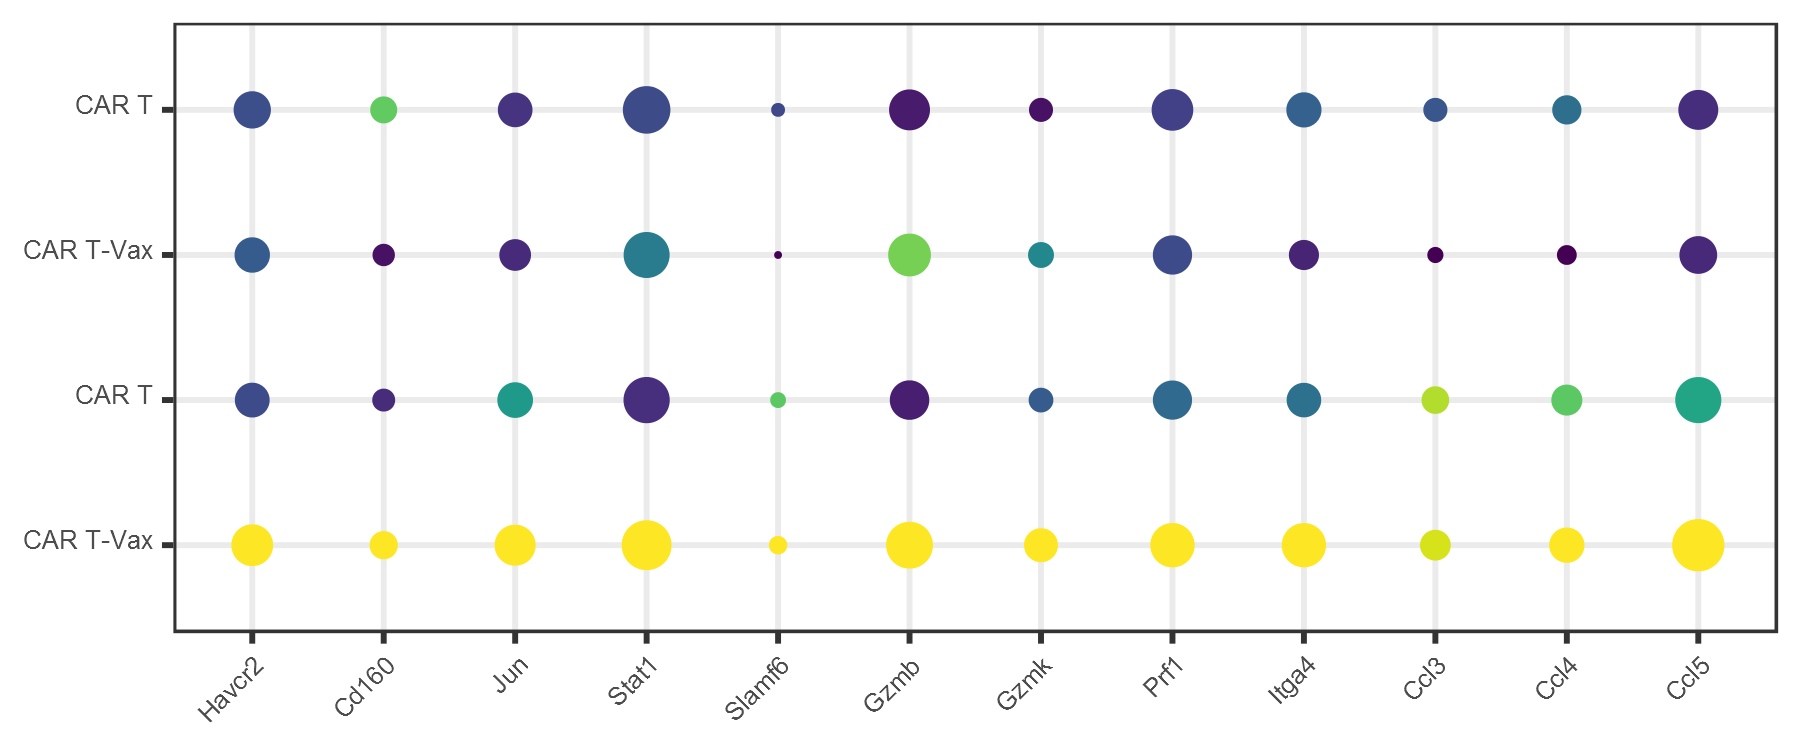

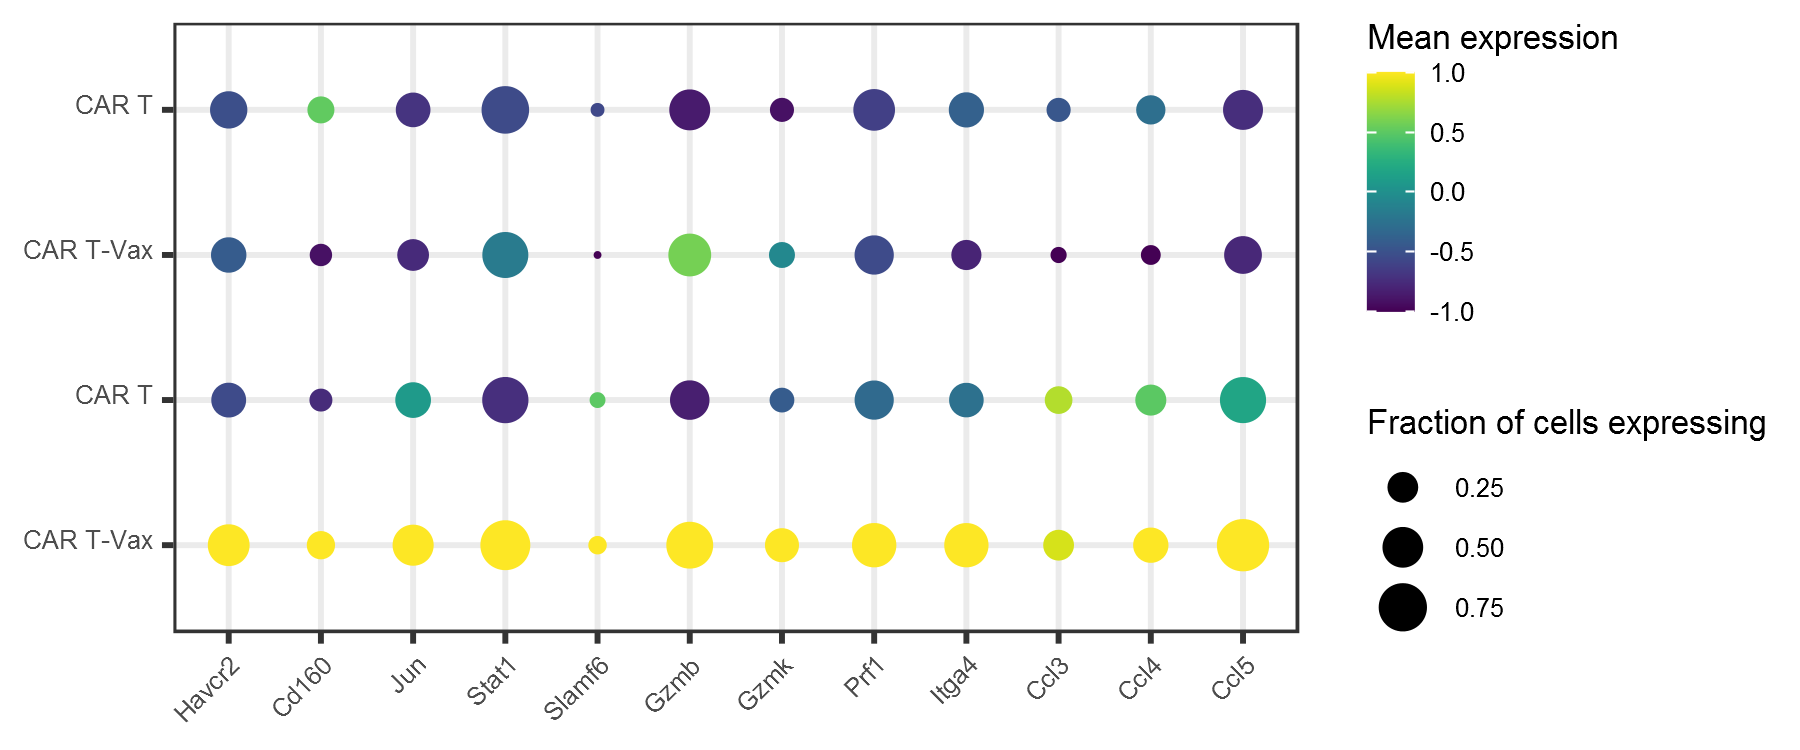

In [25]:
library(reshape2)
library(viridis)
options(repr.plot.height = 2.5,repr.plot.width = 6)
length(genes)
genes = unique(c('HAVCR2','CD160', 'JUN','STAT1', 'Slamf6','GZMB', 'GZMK', 'PRF1', 'ITGA4', 'CCL3', 'CCL4', 'CCL5'))# 'IL17A','TMEM176B', 'IL17RE', 'RORC','ITGB1', 'TCF7', 'CXCR3', 'SLAMF6', 'IL13', 'IL5' ,'PPARG', 'IL1RL1'))
genes[!genes %in% rownames(seurat2@data)]
genes = str_to_title(genes)
data = as.data.frame(t(as.matrix(seurat2@data[genes,])))
data$phenotype = paste0(seurat2@meta.data$group_time)
data = data[seurat2@meta.data$pheno == 'CD8+ CTL',]
df_exp = data %>% group_by(phenotype) %>% summarize_all(.funs = list(meanexp)) %>% as.data.frame() 
df_exp[,2:(1+length(genes))] = scale(df_exp[,2:(1+length(genes))])
df_exp = df_exp %>% melt(id.vars = 'phenotype')
df_pct = data %>% group_by(phenotype) %>% summarize_all(.funs = list(pct)) %>% melt(id.vars = 'phenotype')
df_exp$value[df_exp$value > 1] = 1
df_exp$value[df_exp$value < -1]= -1
df_exp$pct = df_pct$value


lvs = levels(factor(df_exp$phenotype))
ggplot(as.data.frame(df_exp), aes(y = phenotype, x = variable, size = pct, color = value)) + geom_point() + scale_color_viridis()  + 
 theme_bw()  + theme(axis.title = element_blank(), axis.text.x = element_text(angle =45, hjust = 1)) + 
labs(color = "Mean expression", size = 'Fraction of cells expressing') + scale_x_discrete(limits = genes, labels = str_to_title(genes)) + Axis_themes + 
theme(axis.title = element_blank(), axis.text = element_text(size = 6, hjust = 1, vjust = .2))  + guides(size = FALSE, color = FALSE) + 
scale_y_discrete(limits = rev (levels(seurat2@meta.data$group_time)), labels = rev(c('CAR T', 'CAR T-Vax', 'CAR T', 'CAR T-Vax'))) + 

scale_size_continuous(range = c(0, 5))+ 
guides(color = guide_colorbar(barheight = 4,barwidth = .8), size = guide_legend(keyheight = 1)) + guides(color = FALSE, size = FALSE)

ggsave('Figures/cd8markers.pdf',  height = 1.2, width = 2.5,useDingbats = FALSE)

ggplot(as.data.frame(df_exp), aes(y = phenotype, x = variable, size = pct, color = value)) + geom_point() + scale_color_viridis()  + 
 theme_bw()  + theme(axis.title = element_blank(), axis.text.x = element_text(angle =45, hjust = 1)) + 
labs(color = "Mean expression", size = 'Fraction of cells expressing') + scale_x_discrete(limits = genes, labels = str_to_title(genes)) + Axis_themes + 
theme(axis.title = element_blank(), axis.text = element_text(size = 6, hjust = 1, vjust = .2))  + guides(size = FALSE, color = FALSE) + 
scale_y_discrete(limits = rev (levels(seurat2@meta.data$group_time)), labels = rev(c('CAR T', 'CAR T-Vax', 'CAR T', 'CAR T-Vax'))) + 

scale_size_continuous(range = c(0, 5))+ 
guides(color = guide_colorbar(barheight = 4,barwidth = .8), size = guide_legend(keyheight = 1)) 

ggsave('Figures/cd8markers_legend.pdf',  height = 3, width = 2.5,useDingbats = FALSE)


[1] 12

[1] "IFNG"     "TCF7"     "CXCR3"    "SLAMF6"   "IL17A"    "TMEM176B"
 [7] "IL17RE"   "RORC"     "IL13"     "IL5"      "PPARG"    "IL1RL1"

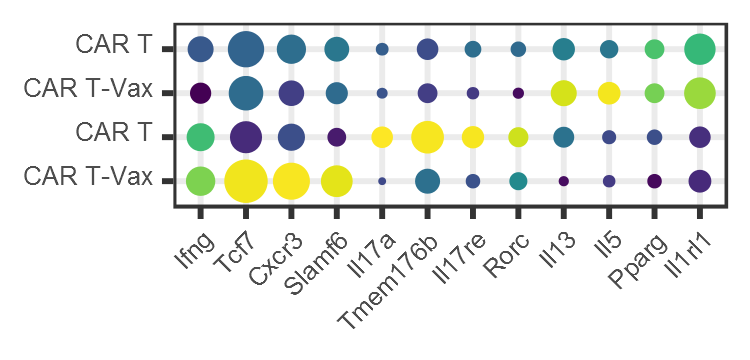

In [26]:
options(repr.plot.height = 1.2, repr.plot.width = 2.5)
genes = c('IFNG', 'TCF7', 'CXCR3', 'SLAMF6', 'IL17A','TMEM176B', 'IL17RE', 'RORC','IL13', 'IL5' ,'PPARG', 'IL1RL1')
length(genes)
genes[!genes %in% rownames(seurat2@data)]
genes = str_to_title(genes)
data = as.data.frame(t(as.matrix(seurat2@data[genes,])))
data$phenotype = seurat2@meta.data$group_time
data = data[seurat2@meta.data$pheno == 'CD4+ Th',]
df_exp = data %>% group_by(phenotype) %>% summarize_all(.funs = list(meanexp)) %>% as.data.frame() 
df_exp[,2:(1+length(genes))] = scale(df_exp[,2:(1+length(genes))])
df_exp = df_exp %>% melt(id.vars = 'phenotype')
df_pct = data %>% group_by(phenotype) %>% summarize_all(.funs = list(pct)) %>% melt(id.vars = 'phenotype')
df_exp$value[df_exp$value > 2.5] = 2.5
df_exp$value[df_exp$value < -1.5]= -1.5
df_exp$pct = df_pct$value


lvs = levels(factor(df_exp$phenotype))
ggplot(as.data.frame(df_exp), aes(y = phenotype, x = variable, size = pct, color = value)) + geom_point() + scale_color_viridis()  + 
 theme_bw()  + theme(axis.title = element_blank(), axis.text.x = element_text(angle = 45, hjust = 1)) + 
labs(color = "Mean expression", size = 'Fraction of cells expressing') + scale_x_discrete(limits = genes, labels = str_to_title(genes)) + Axis_themes + 
theme(axis.title = element_blank(), axis.text = element_text(size = 6, hjust = 1, vjust = .2))  + guides(size = FALSE, color = FALSE) + 
scale_y_discrete(limits = rev (levels(seurat2@meta.data$group_time)), labels = rev(c('CAR T', 'CAR T-Vax', 'CAR T', 'CAR T-Vax'))) + 
scale_size_continuous(range = c(0, 4)) + guides(color = FALSE, size = FALSE)

ggsave('Figures/cd4markers.pdf', height = 1.2, width = 2.5, useDingbats = FALSE)



In [27]:
data = read.csv('p15E_TCR.csv', stringsAsFactors = FALSE)
head(data)

,X,nGene,nUMI,orig.ident,orig,bc,n_genes,n_counts,leiden,UMAP1,...,TRBV,TRBJ,TRA_CDR3,TRAV,TRAJ,TRA.2_CDR3,TRAV.2,TRAJ.2,chip,TRB_count
,<chr>,<int>,<int>,<chr>,<chr>,<chr>,<int>,<int>,<int>,<dbl>,...,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>
1,B9_1,3582,19089,B9,B9,AAAACGTTCGGT,3581,19088,7,-1.9126217,...,TRBV13-1,TRBJ2-4,NA,NA,NA,NA,NA,NA,B9,2
2,B9_6,2246,7316,B9,B9,AACACACCCTAG,2246,7316,1,-0.9023601,...,TRBV16,TRBJ2-7,NA,NA,NA,NA,NA,NA,B9,19
3,B9_11,5569,32470,B9,B9,AACAGACGAGCG,5568,32469,0,-1.7891079,...,TRBV20,TRBJ2-4,CAVSPPDYSNNRLT,TRAV7-3,TRAJ7,NA,NA,NA,B9,3
4,B9_20,491,1698,B9,B9,AACCGTTCACGC,491,1698,6,2.5570545,...,NA,NA,NA,NA,NA,NA,NA,NA,B9,NA
5,B9_25,369,905,B9,B9,AAGAGGATGTCT,369,905,5,-2.4312119,...,NA,NA,NA,NA,NA,NA,NA,NA,B9,NA
6,B9_31,926,4909,B9,B9,AATAAGCTGCTC,926,4909,0,-1.4568304,...,NA,NA,NA,NA,NA,NA,NA,NA,B9,NA


In [28]:
bclones = data %>% filter(!is.na(TRB_CDR3)) %>% group_by(TRB_CDR3, tet) %>% summarize(n = n()) %>% mutate(frac = n/sum(n))
bclones = bclones %>% filter(tet == 'Tet+', frac  > .8, n > 1) %>% arrange(desc(n))

aclones = data %>% filter(!is.na(TRA_CDR3)) %>% group_by(TRA_CDR3, tet) %>% summarize(n = n()) %>% mutate(frac = n/sum(n))
aclones = aclones %>% filter(tet == 'Tet+', frac  > .8, n > 1) %>% arrange(desc(n))

`summarise()` has grouped output by 'TRB_CDR3'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'TRA_CDR3'. You can override using the `.groups` argument.


In [29]:
library(stringdist)
trb = seurat2@meta.data$TRB_CDR3
trb = unique(trb[!is.na(trb)])

dmat = stringdistmatrix(trb,bclones$TRB_CDR3, method = 'lv')
mindist = apply(dmat, 1, min)
names(mindist) = trb
seurat2@meta.data$mindistb = mindist[seurat2@meta.data$TRB_CDR3]
table(seurat2@meta.data$group_time, seurat2@meta.data$mindistb)

                  
                     0   1   2   3   4   5   6   7   8
  CAR T_Day 7       22  66 197 611 391 163  72  23   1
  CAR T-Vax_Day 7   54  37 148 375 504 334  86  22   2
  CAR T_Day 14     130 112 506 863 929 221  62  21   2
  CAR T-Vax_Day 14   1  13  56 140 363  49  61   1   1

In [30]:
tra = seurat2@meta.data$TRA_CDR3
tra = unique(tra[!is.na(tra)])

dmat = stringdistmatrix(tra, aclones$TRA_CDR3, method = 'lv')
mindist = apply(dmat, 1, min)
names(mindist) = tra
seurat2@meta.data$mindista = mindist[seurat2@meta.data$TRA_CDR3]
table(seurat2@meta.data$group_time, seurat2@meta.data$mindista)

                  
                     0   1   2   3   4   5   6   7   8   9  10  11  12  15  17
  CAR T_Day 7       32 164 425 460 502 412 150 146 113  17   3   1   0   0   0
  CAR T-Vax_Day 7   40 116 248 490 369 215 208 133  76  30   6   1   0   1   1
  CAR T_Day 14      82 143 439 549 455 274 223 162 122  47  45   2   1   0   0
  CAR T-Vax_Day 14   2  15  27  19  31 204  11  10  11   2   1   0   0   0   0
                  
                    18  23
  CAR T_Day 7        0   1
  CAR T-Vax_Day 7    1   0
  CAR T_Day 14       0   0
  CAR T-Vax_Day 14   0   0

In [31]:
seurat2@meta.data$alpha_motif = NA
seurat2@meta.data$alpha_motif[grep(seurat2@meta.data$TRA_CDR3, pattern = 'DYSNNRLT')] = 'Yes'
seurat2@meta.data$mindistb[is.na(seurat2@meta.data$mindistb)] = 15
seurat2@meta.data$mindista[is.na(seurat2@meta.data$mindista)] = 15
seurat2@meta.data$alpha_motif[is.na(seurat2@meta.data$alpha_motif)] = 'No'
seurat2@meta.data$p15 = as.numeric(seurat2@meta.data$mindistb <2 | seurat2@meta.data$mindista <1 | seurat2@meta.data$alpha_motif == 'Yes')


Loading required package: magrittr


Attaching package: 'ggpubr'


The following object is masked from 'package:cowplot':

    get_legend


`summarise()` has grouped output by 'group_time'. You can override using the `.groups` argument.
Warning message:
"Removed 4 rows containing missing values (geom_text)."
Warning message:
"Removed 4 rows containing missing values (geom_text)."


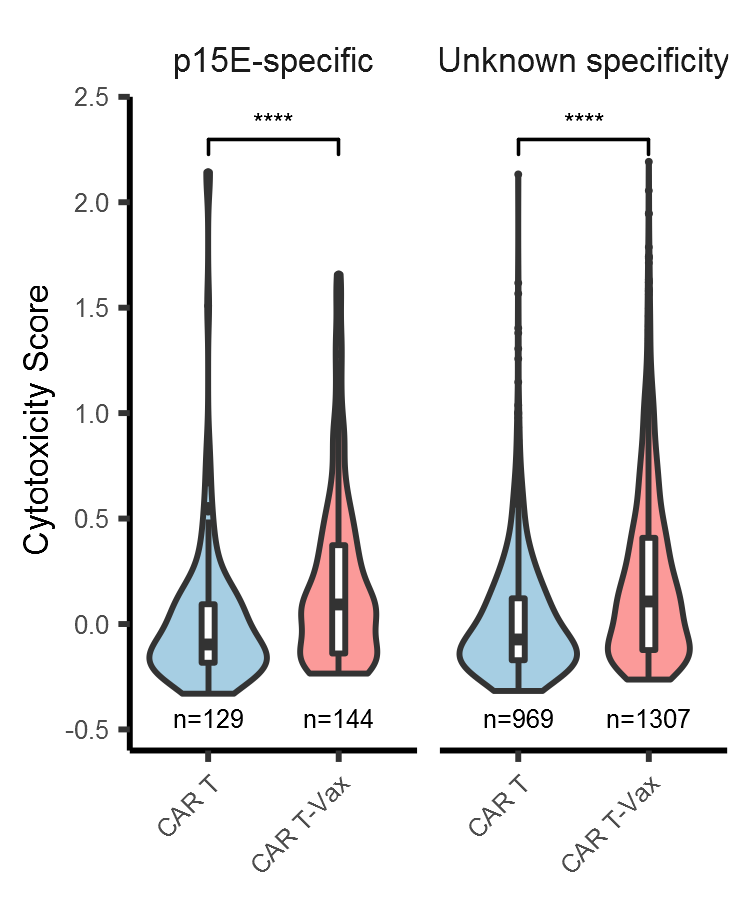

In [32]:
library(ggpubr)

gzm = rownames(seurat2@data)[grep(x = rownames(seurat2@data), pattern = "Gzm")]
seurat2 = AddModuleScore(seurat2, genes.list = list(list1 = c(gzm)))


seurat2@meta.data$p15E = ifelse(seurat2@meta.data$p15 == 1, 'p15E-specific', 'Unknown specificity')
count = seurat2@meta.data %>% filter(!(is.na(TRB_CDR3) &(is.na(TRA_CDR3))), pheno == 'CD8+ CTL') %>% group_by(group_time,
                                                                                        p15E) %>% summarize(n = n()) %>% mutate(n = paste0('n=', n))
library(RColorBrewer)
condition_palette = brewer.pal(10, 'Paired')[c(6,5,2,1)][c(4,2,3,1)]

options(repr.plot.height = 3, repr.plot.width = 2.5)


p=ggplot(seurat2@meta.data %>% filter(!(is.na(TRB_CDR3) &(is.na(TRA_CDR3))), time == 'Day 7', pheno == 'CD8+ CTL'), aes(x = group_time, y = Cluster1)) + 
geom_violin(aes(fill = group_time), bw = .1) + geom_boxplot(width = .1, outlier.size = 0) + # geom_jitter(size = .01) + 
geom_text(data =count, aes(x = group_time, label = n), y = -.45, size = 2.1167) + facet_wrap('p15E') +
stat_compare_means(comparisons = list(c(1,2), c(3,4)),  label.y = 2.3, label = 'p.signif') + 
scale_x_discrete(labels = c('CAR T', 'CAR T-Vax'), limits = c('CAR T_Day 7', 'CAR T-Vax_Day 7')) + labs(x = c(), y = 'Cytotoxicity Score') + theme_classic() +  Axis_themes + 
scale_y_continuous(limits = c(-.6, 2.5), expand = c(0,0)) + scale_fill_manual(values = condition_palette) + guides(fill = FALSE) + 
theme(strip.background = element_blank(), axis.text.x = element_text(angle = 45, hjust = 1))
p$layers[[4]]$aes_params$textsize <- 2.1167
p

ggsave('Figures/p15E.pdf', height = 3, width = 4, useDingbats = FALSE)